### 导入实验环境

https://bbs.huaweicloud.com/blogs/344369

#### 导入库

In [4]:
import os
import struct
import sys
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
import numpy as np

import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import context
from mindspore.nn.metrics import Accuracy, Loss
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore import Tensor

context.set_context(mode=context.GRAPH_MODE, device_target='CPU') 


#### 定义常量

In [5]:
cfg = edict({
    'train_size': 60000,  # 训练集大小
    'test_size': 10000,  # 测试集大小
    # 'train_size': 600,  # 训练集大小
    # 'test_size': 100,  # 测试集大小
    'channel': 1,  # 图片通道数
    'image_height': 28,  # 图片高度
    'image_width': 28,  # 图片宽度
    'batch_size': 64,
    'num_classes': 10,  # 分类类别
    'lr': 0.001,  # 学习率
    'epoch_size': 3,  # 训练次数
    'data_dir_train': os.path.join('fashion-mnist', 'train'),
    'data_dir_test': os.path.join('fashion-mnist', 'test'),
}) 


### 数据读取和预处理

#### 步骤 1	定义函数用于读取数据

In [6]:
def read_image(file_name):
    '''
    :param file_name: 文件路径
    :return:  训练或者测试数据
    如下是训练的图片的二进制格式
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>IIII', file_content, 0)  # 取前4个整数，返回一个元组
    offset = struct.calcsize('>IIII')
    imgNum = head[1]  # 图片数
    width = head[2]  # 宽度
    height = head[3]  # 高度
    bits = imgNum * width * height  # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    imgs_array = np.array(imgs, np.float32).reshape((imgNum, width * height))  # 最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array


def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label, np.int32)


def get_data():
    # 文件获取
    train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
    test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
    train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
    test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
    # 读取数据
    train_x = read_image(train_image)
    test_x = read_image(test_image)
    train_y = read_label(train_label)
    test_y = read_label(test_label)
    return train_x, train_y, test_x, test_y


#### 数据预处理

训练数据集样本数： 60000
测试数据集样本数： 10000
通道数/图像长/宽： (1, 28, 28)
一张图像的标签样式： 9


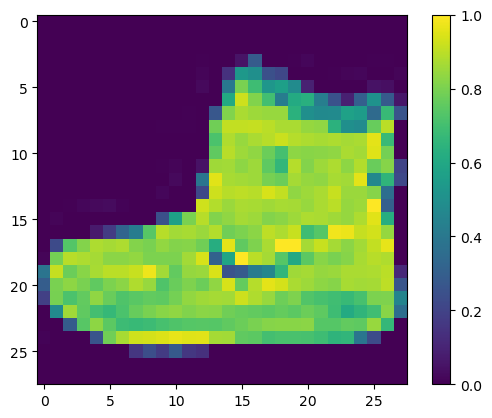

In [7]:
train_x, train_y, test_x, test_y = get_data()
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
train_x = train_x / 255.0
test_x = test_x / 255.0

print('训练数据集样本数：', train_x.shape[0])
print('测试数据集样本数：', test_y.shape[0])
print('通道数/图像长/宽：', train_x.shape[1:])
print('一张图像的标签样式：', train_y[0])  # 一共10类，用0-9的数字表达类别。

plt.figure()
plt.imshow(train_x[0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()


#### 数据集预处理

In [8]:
# 转换数据类型为Dataset
def create_dataset():
    XY_train = list(zip(train_x, train_y))
    ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
    ds_train = ds_train.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    XY_test = list(zip(test_x, test_y))
    ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
    ds_test = ds_test.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    return ds_train, ds_test 


### 回调函数声明

In [20]:
# 定义一个自定义的回调函数，继承自Callback类
from mindspore.train.callback import Callback
class EvalCallBack(Callback):
    def __init__(self, model, train_dataset, test_dataset, dataset_sink_mode = False, epochs_to_eval = 1):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        # epochs_to_eval是一个int数字，代表着：每隔多少个epoch进行一次验证
        self.epochs_to_eval = epochs_to_eval
        self.per_eval = {"epoch": [], "test_acc": [], "train_acc": [], "test_loss": [], "train_loss": []}
        self.dataset_sink_mode = dataset_sink_mode

    def epoch_end(self, run_context):
        # 获取到现在的epoch数
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        # 如果达到进行验证的epoch数，则进行以下验证操作
        if cur_epoch % self.epochs_to_eval == 0:
            # 此处model设定的metrics是准确率Accuracy
            train_acc = self.model.eval(self.train_dataset, dataset_sink_mode=self.dataset_sink_mode)["train_acc"]
            test_acc = self.model.eval(self.test_dataset, dataset_sink_mode=self.dataset_sink_mode)["test_acc"]
            train_loss = self.model.eval(self.train_dataset, dataset_sink_mode=self.dataset_sink_mode)["train_loss"]
            test_loss = self.model.eval(self.test_dataset, dataset_sink_mode=self.dataset_sink_mode)["test_loss"]
            self.per_eval["epoch"].append(cur_epoch)
            self.per_eval["test_acc"].append(test_acc)
            self.per_eval["train_acc"].append(train_acc)
            self.per_eval["train_loss"].append(test_acc)
            self.per_eval["test_loss"].append(train_acc)
            print("Epoch{}: train_acc: {}, test_acc: {}, train_loss: {}, test_loss{}".format(cur_epoch, train_acc, test_acc, train_loss, test_loss))


### BaseLine

In [21]:
# 定义卷积神经网络，BaseLine
class ForwardFashion(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashion, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(128 * 11 * 11, 128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_baseline(Net):
    ds_train, ds_test = create_dataset()
    # 构建网络
    network = Net(cfg.num_classes)
    # 定义模型的损失函数，优化器    
    net_loss = nn.CrossEntropyLoss(reduction="mean")
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'test_acc': Accuracy(), 'train_acc': Accuracy(), 'test_loss': Loss(),  'train_loss': Loss()})
    loss_cb = EvalCallBack(model=model, train_dataset=ds_train, test_dataset=ds_test)
    print("============== Starting Training ==============")
    model.train(cfg.epoch_size, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    # 验证
    # metric = model.eval(ds_test)
    # print(metric)
    print(loss_cb.per_eval)
    return model

model_baseline = train_baseline(ForwardFashion)

[WARNING] ME(1372:23460,MainProcess):2023-05-17-20:14:25.114.551 [mindspore\train\model.py:1094] For EvalCallBack callback, {'epoch_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


============== Starting Training ==============
Epoch1: train_acc: 0.8770344183564568, test_acc: 0.8633814102564102, train_loss: 0.34073136174373464, test_loss0.370715688340939
Epoch2: train_acc: 0.9069003468516542, test_acc: 0.8912259615384616, train_loss: 0.25413589111132706, test_loss0.29558108823421675
Epoch3: train_acc: 0.9294123532550693, test_acc: 0.9089543269230769, train_loss: 0.1947810051797739, test_loss0.2562385921199352
{'epoch': [1, 2, 3], 'test_acc': [0.8633814102564102, 0.8912259615384616, 0.9089543269230769], 'train_acc': [0.8770344183564568, 0.9069003468516542, 0.9294123532550693], 'test_loss': [0.8770344183564568, 0.9069003468516542, 0.9294123532550693], 'train_loss': [0.8633814102564102, 0.8912259615384616, 0.9089543269230769]}


### BN正则化

In [ ]:
# 定义卷积神经网络，批量归一化
class ForwardFashionWithBatchNorm(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionWithBatchNorm, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(3200, 128)
        self.bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        # x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        # x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_BN(Net):
    ds_train, ds_test = create_dataset()
    # 构建网络
    network = Net(cfg.num_classes)
    # 定义模型的损失函数，优化器
    net_loss = nn.CrossEntropyLoss(reduction="mean")
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'acc': Accuracy()})
    loss_cb = LossMonitor()
    print("============== Starting Training ==============")
    model.train(cfg.epoch_size, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    # 验证
    metric = model.eval(ds_test)
    print(metric)
    
    return model

model_bn = train_BN(ForwardFashionWithBatchNorm)

### Dropout正则化

In [ ]:
# 定义卷积神经网络，有Dropout正则化
class ForwardFashionWithDropout(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionWithDropout, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(3200, 128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_dp(Net):
    ds_train, ds_test = create_dataset()
    # 构建网络
    network = Net(cfg.num_classes)
    # 定义模型的损失函数，优化器
    net_loss = nn.CrossEntropyLoss(reduction="mean")
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'acc': Accuracy()})
    loss_cb = LossMonitor()
    print("============== Starting Training ==============")
    model.train(cfg.epoch_size, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    # 验证
    metric = model.eval(ds_test)
    print(metric)
    
    return model

model_dp = train_dp(ForwardFashionWithDropout)

### L1正则化

In [ ]:
from mindspore import ops
# 定义卷积神经网络，BaseLine
class ForwardFashionWithRegL1(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionWithRegL1, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(128 * 11 * 11, 128)
        self.fc2 = nn.Dense(128, self.num_class)
        self.l1Reg = nn.L1Regularizer(0.5)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x



# 定义具有L1正则化的交叉熵损失函数
class L1CrossEntropyLoss(nn.Cell):
    def __init__(self, params, l1_weight = 1e-4, reduction = "mean"):
        super(L1CrossEntropyLoss, self).__init__(reduction)
        self.params = params
        self.ce = nn.CrossEntropyLoss()
        self.l1 = nn.L1Regularizer(l1_weight)
        self.reduce_sum = ops.ReduceSum()
        self.concat = ops.Concat(axis=0)
        self.reshape = ops.Reshape()

    def construct(self, pred, label):
        flatten_params = self.concat([self.reshape(p, (-1,)) for p in self.params])
        ce_loss = self.ce(pred, label)
        l1_loss = self.reduce_sum(self.l1(flatten_params))      # 计算L1范数惩罚项
        total_loss = ce_loss + l1_loss
        return total_loss

def train_regL1(Net):
    ds_train, ds_test = create_dataset()
    # 构建网络
    network = Net(cfg.num_classes)
    # 定义模型的损失函数，优化器
    net_loss = L1CrossEntropyLoss(network.trainable_params())
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'acc': Accuracy()})
    loss_cb = LossMonitor()
    print("============== Starting Training ==============")
    model.train(cfg.epoch_size, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    # 验证
    metric = model.eval(ds_test)
    print(metric)
    return model

model_regL1 = train_regL1(ForwardFashionWithRegL1)

### L2正则化

In [ ]:
from mindspore import ops
# 定义卷积神经网络，BaseLine
class ForwardFashionWithRegL2(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionWithRegL2, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(128 * 11 * 11, 128)
        self.fc2 = nn.Dense(128, self.num_class)
        self.l1Reg = nn.L1Regularizer(0.5)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# 定义超参数

# 定义具有L2正则化的交叉熵损失函数
class L2CrossEntropyLoss(nn.Cell):
    def __init__(self, params, l2_weight = 1e-4, reduction = "mean"):
        super(L2CrossEntropyLoss, self).__init__(reduction)
        self.params = params
        self.ce = nn.CrossEntropyLoss()
        self.l1 = nn.L1Regularizer(1)
        self.l2_weight = l2_weight
        self.reduce_sum = ops.ReduceSum()
        self.concat = ops.Concat(axis=0)
        self.reshape = ops.Reshape()

    def construct(self, pred, label):
        flatten_params = self.concat([self.reshape(p, (-1,)) for p in self.params])
        ce_loss = self.ce(pred, label)
        l1_loss = self.reduce_sum(self.l1(flatten_params)) * self.reduce_sum(self.l1(flatten_params)) * self.l2_weight      # 计算L1范数惩罚项
        total_loss = ce_loss + l1_loss
        return total_loss


def train_regL2(Net):
    ds_train, ds_test = create_dataset()
    # 构建网络
    network = Net(cfg.num_classes)
    # 定义模型的损失函数，优化器
    net_loss = L2CrossEntropyLoss(network.trainable_params())
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'acc': Accuracy()})
    loss_cb = LossMonitor()
    print("============== Starting Training ==============")
    model.train(cfg.epoch_size, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    # 验证
    metric = model.eval(ds_test)
    print(metric)
    return model

model_regL2 = train_regL2(ForwardFashionWithRegL2)

### FTRL不知道是什么玩意的正则化

In [ ]:
# 定义卷积神经网络，BaseLine
class ForwardFashion(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashion, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(128 * 11 * 11, 128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    

def train_FTRL(Net):
    ds_train, ds_test = create_dataset()
    # 构建网络
    network = Net(cfg.num_classes)
    # 定义模型的损失函数，优化器    
    net_loss = nn.CrossEntropyLoss(reduction="mean")
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    conv_params = list(filter(lambda x: 'conv' in x.name, network.trainable_params()))
    no_conv_params = list(filter(lambda x: 'conv' not in x.name, network.trainable_params()))
    group_params = [{'params': conv_params, 'weight_decay': 0.01, 'grad_centralization':True},
                    {'params': no_conv_params},
                    {'order_params': network.trainable_params()}]
    optim = nn.FTRL(group_params, learning_rate=0.1, weight_decay=0.0)
    # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=optim, metrics={'acc': Accuracy()})
    loss_cb = LossMonitor()
    print("============== Starting Training ==============")
    model.train(cfg.epoch_size, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    # 验证
    metric = model.eval(ds_test)
    print(metric)
    return model

model_FTRL = train_FTRL(ForwardFashion)


### 测试

### 可视化结果

In [ ]:
# -------------------定义可视化函数--------------------------------
# 输入预测结果序列，真实标签序列，以及图片序列
# 目标是根据预测值对错，让其标签显示为红色或者蓝色。对：标签为红色；错：标签为蓝色
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # 显示对应图片
    plt.imshow(img, cmap=plt.cm.binary)
    # 显示预测结果的颜色，如果对上了是蓝色，否则为红色
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    # 显示对应标签的格式，样式
    plt.xlabel('{},{:2.0f}% ({})'.format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]), color=color)
# 将预测的结果以柱状图形状显示蓝对红错
def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

import numpy as np
def softmax_np(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x/np.sum(exp_x)
    return softmax_x


In [ ]:
# 预测
ds_test, _ = create_dataset()
test_ = ds_test.create_dict_iterator(output_numpy=True).__next__()
predictions = model_regL2.predict(Tensor(test_['x']))
predictions = predictions.asnumpy()
for i in range(15):
    p_np = predictions[i, :]
    p_list = p_np.tolist()
    print('第' + str(i) + '个sample预测结果：', p_list.index(max(p_list)), '   真实结果：', test_['y'][i])

# 预测15个图像与标签，并展现出来
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    pred_np_ = predictions[i, :]
    pred_np_ = softmax_np(pred_np_)
    plot_image(pred_np_, test_['y'][i], test_['x'][i, 0, ...])
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(pred_np_, test_['y'][i])
plt.show() 


### 参考代码

In [ ]:
# # ref code
# # 定义卷积神经网络，有正则化
# class ForwardFashionRegularization(nn.Cell):
#     def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
#         super(ForwardFashionRegularization, self).__init__()
#         self.num_class = num_class
#         self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
#         self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
#         self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
#         self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout()
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Dense(3200, 128)
#         self.bn = nn.BatchNorm1d(128)
#         self.fc2 = nn.Dense(128, self.num_class)

#     def construct(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.maxpool2d(x)
#         x = self.dropout(x)
#         x = self.conv3(x)
#         x = self.relu(x)
#         x = self.maxpool2d(x)
#         x = self.dropout(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.bn(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

# def train(Net):
#     ds_train, ds_test = create_dataset()
#     # 构建网络
#     network = Net(cfg.num_classes)
#     # 定义模型的损失函数，优化器
#     net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
#     net_opt = nn.Adam(network.trainable_params(), cfg.lr)
#     # 训练模型
#     model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'acc': Accuracy()})
#     loss_cb = LossMonitor()
#     print("============== Starting Training ==============")
#     model.train(cfg.epoch_size, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
#     # 验证
#     metric = model.eval(ds_test)
#     print(metric)
    
#     return model

# # 训练无正则化的网络
# model = train(ForwardFashion)

# # 预测
# ds_test, _ = create_dataset()
# test_ = ds_test.create_dict_iterator(output_numpy=True).__next__()
# predictions = model.predict(Tensor(test_['x']))
# predictions = predictions.asnumpy()
# for i in range(15):
#     p_np = predictions[i, :]
#     p_list = p_np.tolist()
#     print('第' + str(i) + '个sample预测结果：', p_list.index(max(p_list)), '   真实结果：', test_['y'][i])

